In [4]:
# Specify inline plots for notebook
%matplotlib inline
from matplotlib.font_manager import FontProperties

# Libraries -- overkill for the time being
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
jet=plt.get_cmap('coolwarm')
sites = ['Vcm','Vcp','Mpj','Wjs','Ses','Seg']



gcolour=[0.9,0.5, 0.0];
ngcolour=[0.9, 0.6, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pjgcolour=[0.2, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];
siteColors = [mcolour, pcolour, pjcolour, jcolour, scolour, gcolour]

# Set working dir
laptopdir = '/home/nikko/Research/AGU_DATA/'
#wrkDir = 'C:/Research/AGU_2015/'
# Set Amflux data dir
#amfluxDir = 'C:/Research/Ameriflux/'
wrkDir = laptopdir
amfluxdir = laptopdir
MODIS = pd.read_csv(wrkDir + 'allMODIS.csv')
MODISEVI = pd.read_csv(wrkDir + 'allMODISEVI.csv')

In [5]:
def fitLinRegression(sitename, filetype, year, day_start, day_stop):
    idx = 0
    slope = []
    intercept = []
    fitstats = []
    sigvalues_a = []
    sigvalues_b = []
    fitday = []
    specificSite = [s for s in filelist if sitename in s]
    siteSubset = [s for s in specificSite if filetype in s]
    yearSubset = [s for s in siteSubset if year in s]
    tempheader = pd.read_csv(halfHourlyData + yearSubset[0], sep = ',', skiprows = 3, parse_dates=True)
    dataDict = pd.read_csv(halfHourlyData + yearSubset[0], sep = ',', skiprows = 4, parse_dates=True)
    headernames = list(tempheader.columns)
    dataDict.columns = headernames
    dataDict['dt'] = dataDict['TIMESTAMP'].apply(lambda x: pd.to_datetime(str(x),'%Y%M%D%H%M%S'))
    dataDict.index = dataDict.dt
    dataDict['MONTH'] = dataDict.index.month
    dataDict['DOY'] = dataDict.index.dayofyear
    dataDict['HOUR'] = dataDict.index.hour
    dataDict['SECOND'] = dataDict.index.second
    
    for day in numpy.arange(day_start, day_stop, 1):
        dailyData = dataDict[dataDict['DOY'] == day]
        ols = smf.ols('GPP ~ PAR', dailyData).fit()
        ols_ci = ols.conf_int().ix['PAR'].tolist()
        olsdict = dict(a = ols.params['Intercept'],
               b = ols.params['PAR'],
               lb = ols_ci[0],
               ub = ols_ci[1])
        slope.append(ols.params['PAR'])
        intercept.append(ols.params['Intercept'])
        fitstats.append(ols.rsquared)
        sigvalues_a.append(ols.pvalues[0])
        sigvalues_b.append(ols.pvalues[1])
        fitday.append(day)
    idx = idx + 1
    return intercept, slope, sigvalues_a, sigvalues_b

In [6]:
MODIS.index = pd.to_datetime(MODIS['Unnamed: 0'])
MODIS_Monthly = MODIS.groupby([MODIS.index.year, MODIS.index.month]).mean().reset_index()
MODIS_Monthly.columns = ['Year','Month','Mpj','Seg','Ses','Vcm','Vcp','Wjs']

MODISEVI.index = pd.to_datetime(MODISEVI['Unnamed: 0'])
MODISEVI_Monthly = MODISEVI.groupby([MODISEVI.index.year, MODISEVI.index.month]).mean().reset_index()
MODISEVI_Monthly.columns = ['Year','Month','Mpj','Seg','Ses','Vcm','Vcp','Wjs']

idx = 0
for site in sites:
    data = pd.read_csv(wrkDir + 'monthly_spei_flux_' + site + '.csv')
    cnames = data.columns.values 
    cnames[0] = 'Time'
    data.columns = cnames
    data.index = pd.to_datetime(data['Time'])
    toAppend = MODISEVI_Monthly[MODISEVI_Monthly.Year > 2006]
    toAppend = toAppend[toAppend.Year < 2015]
    data = data[data.index.year < 2015]
    sitendvi = pd.DataFrame(dict(NDVI = toAppend[site]))
    sitendvi.index = data.index
    data['evi'] = sitendvi
    data = data[(data.index.month > 3) & (data.index.month < 10)]

    mons = np.arange(3,5,1)
    for mon in mons:
        spei = 'spei' + str(mon) + 'mon'
        bin_min = -2
        bin_max = 2
        bin_size = 0.2
        yy = []
        err = []
        count = []
        fig, (ax) = plt.subplots(1,1, figsize=(5,5))
        bins = np.arange(bin_min,bin_max,bin_size)
        for binx in bins:
            yy.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].evi.mean())
            err.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].evi.std())
            count.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].evi.count())
            stderr = err / np.sqrt(count)

        #print bins, yy
        ax.errorbar(bins, yy, yerr=stderr)        
        ax.plot(bins, yy, '--o', color = siteColors[idx])        
        ax.set_title(site + ' ' + spei)
        sns.despine()
        #plt.close();
    idx = idx + 1


idx = 0
for site in sites:
    data = pd.read_csv(wrkDir + 'monthly_spei_flux_' + site + '.csv')
    cnames = data.columns.values 
    cnames[0] = 'Time'
    data.columns = cnames
    data.index = pd.to_datetime(data['Time'])
    toAppend = MODIS_Monthly[MODIS_Monthly.Year > 2006]
    toAppend = toAppend[toAppend.Year < 2015]
    data = data[data.index.year < 2015]
    sitendvi = pd.DataFrame(dict(NDVI = toAppend[site]))
    sitendvi.index = data.index
    data['ndvi'] = sitendvi
    data = data[(data.index.month > 3) & (data.index.month < 10)]

    mons = np.arange(1,12,1)
    for mon in mons:
        spei = 'spei' + str(mon) + 'mon'
        bin_min = -2
        bin_max = 2
        bin_size = 0.2
        yy = []
        err = []
        count = []
        fig, (ax) = plt.subplots(1,1, figsize=(5,5))
        bins = np.arange(bin_min,bin_max,bin_size)
        for binx in bins:
            yy.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].ndvi.mean())
            err.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].ndvi.std())
            count.append(data[(data[spei] >= binx) & (data[spei] < binx + bin_size)].ndvi.count())
            stderr = err / np.sqrt(count)

        #print bins, yy
        ax.errorbar(bins, yy, yerr=stderr)        
        ax.plot(bins, yy, '--o', color = siteColors[idx])        
        ax.set_title(site + ' ' + spei)
        sns.despine()
        #plt.close();
    idx = idx + 1


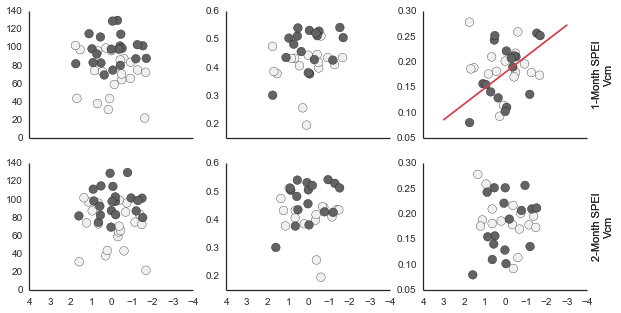

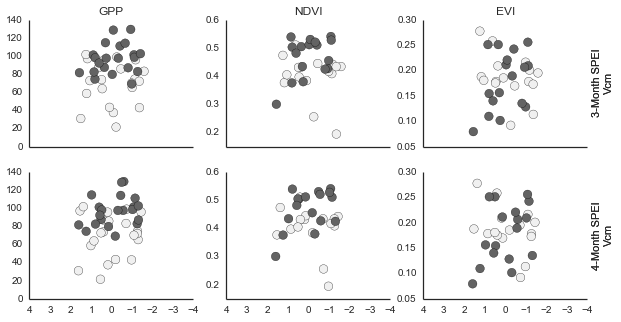

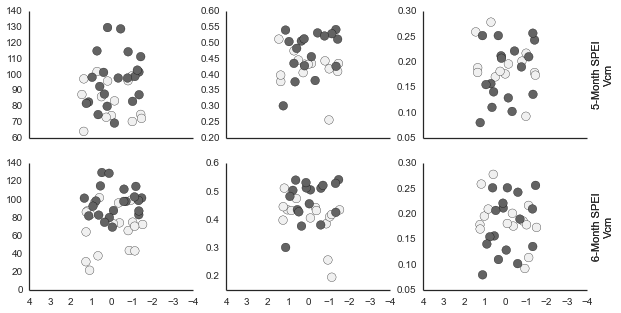

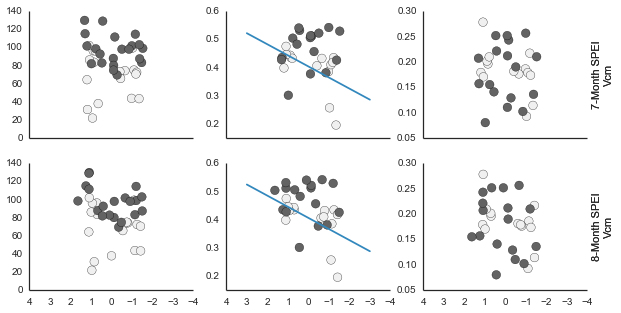

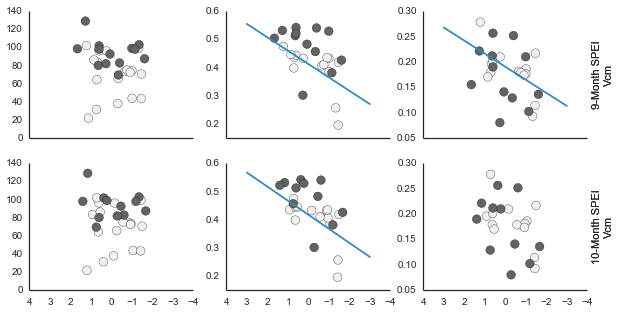

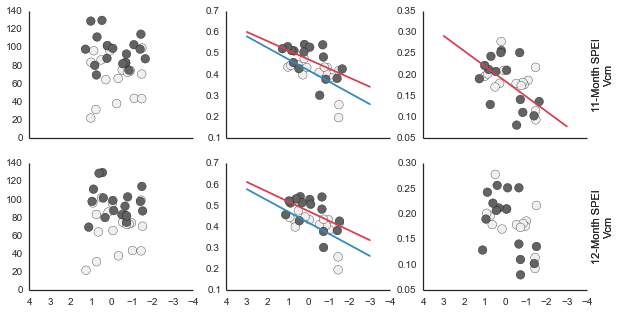

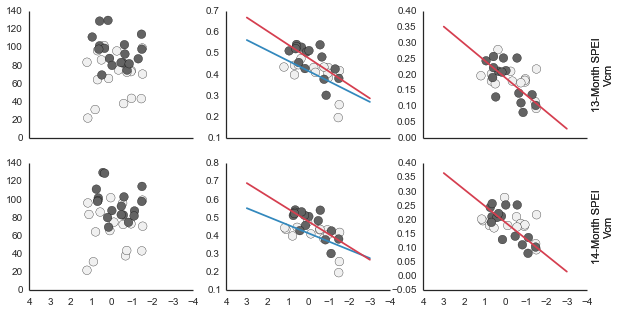

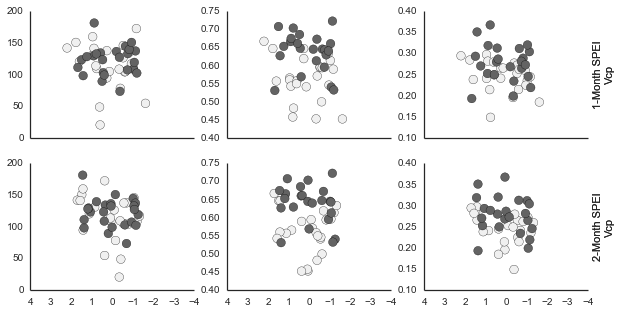

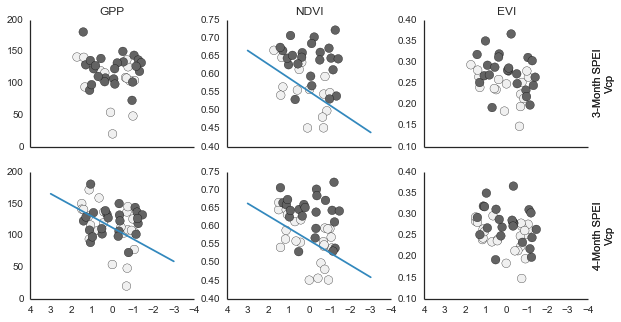

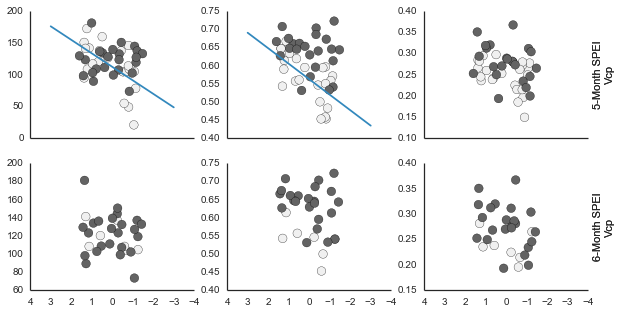

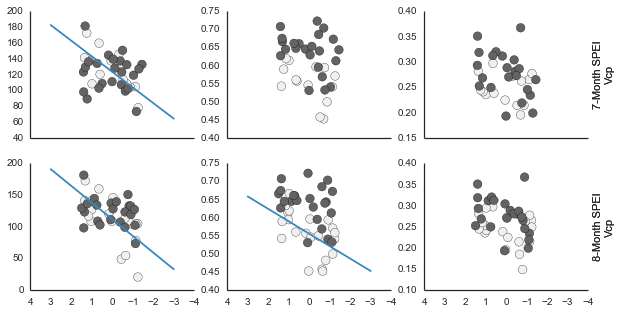

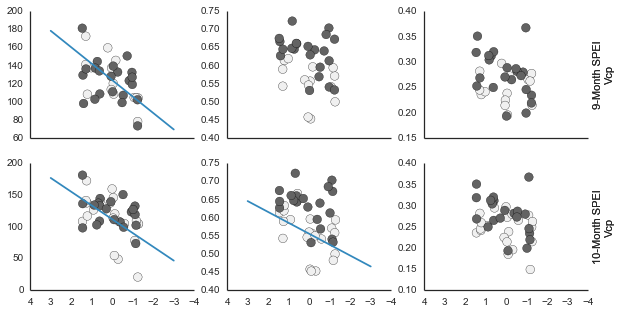

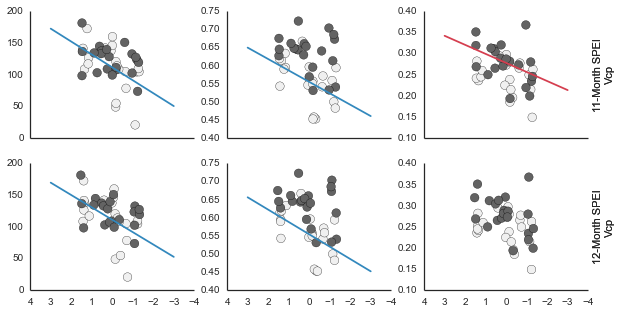

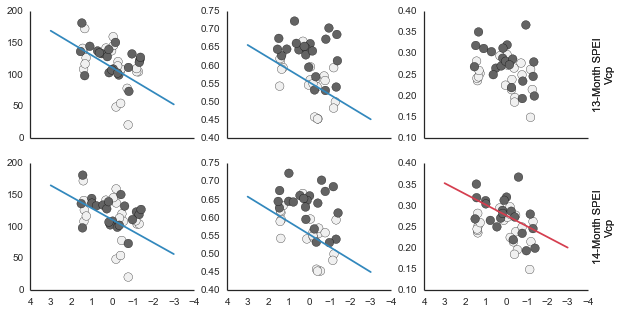

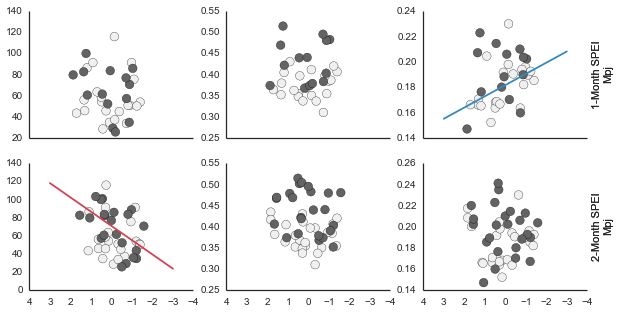

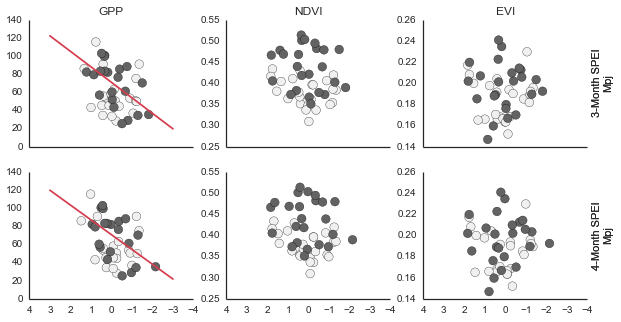

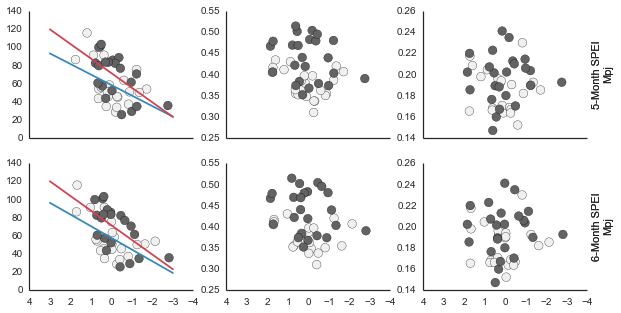

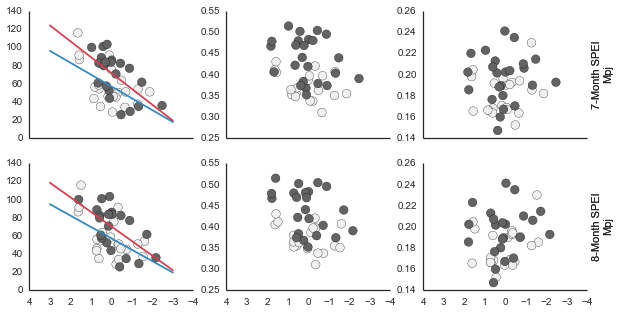

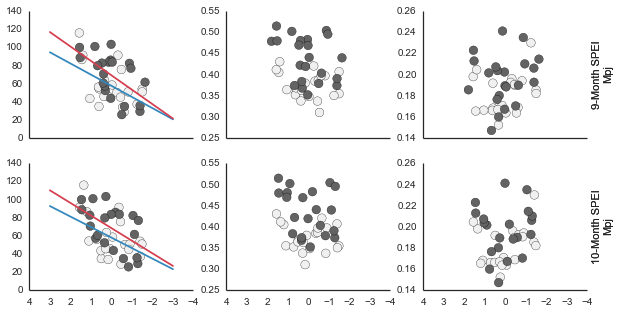

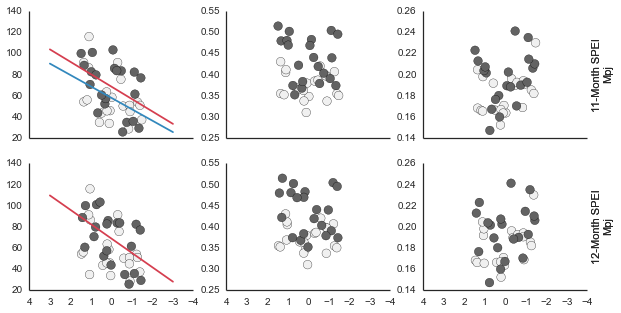

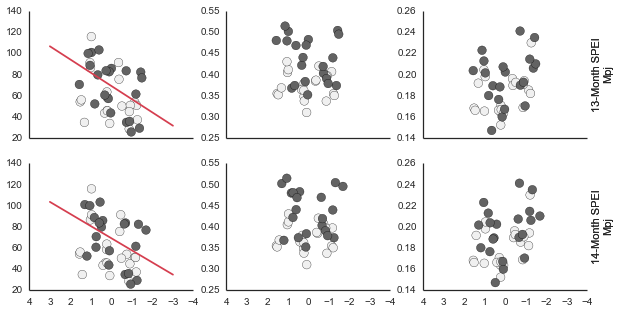

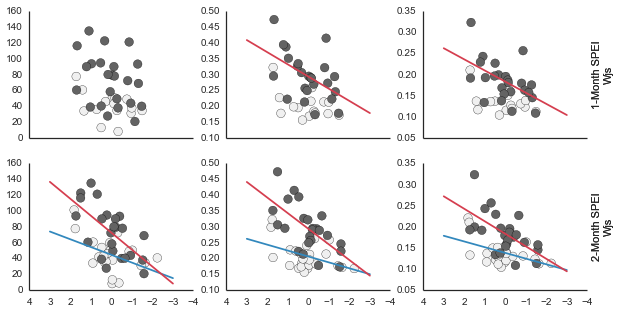

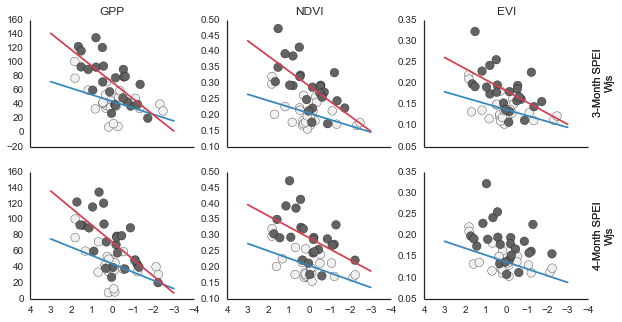

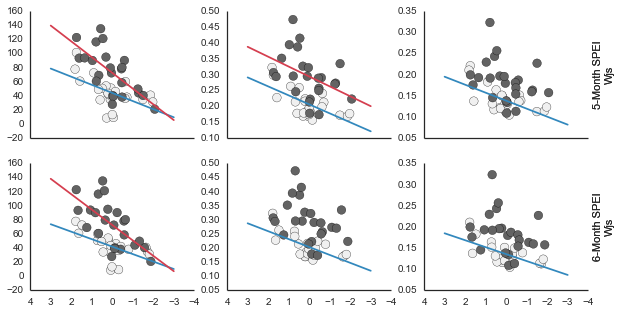

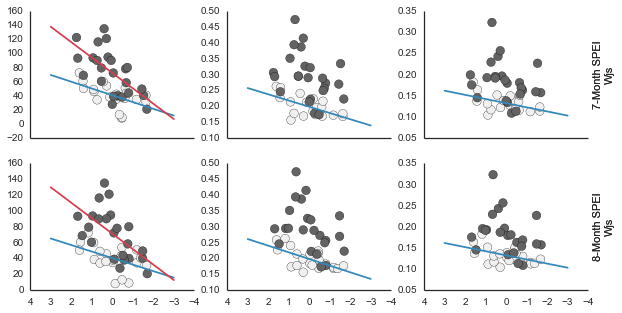

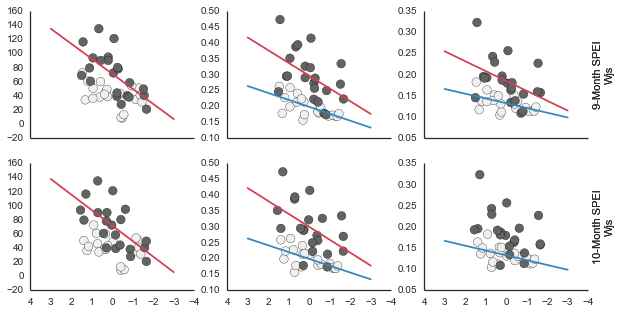

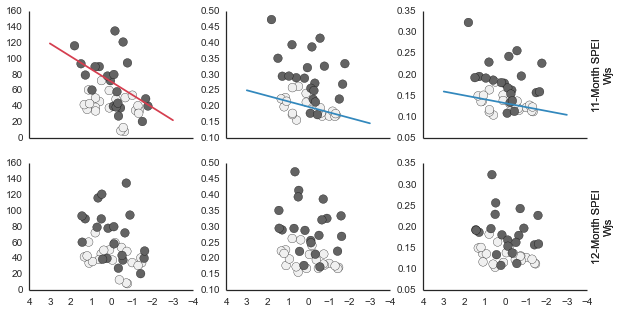

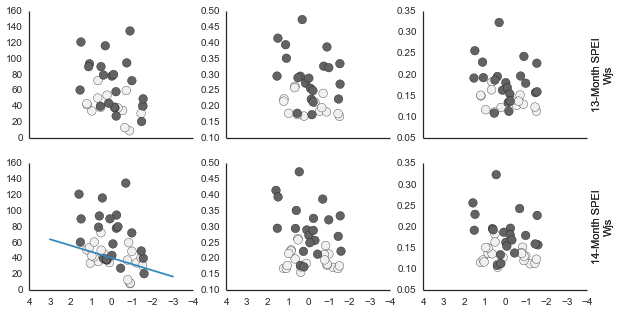

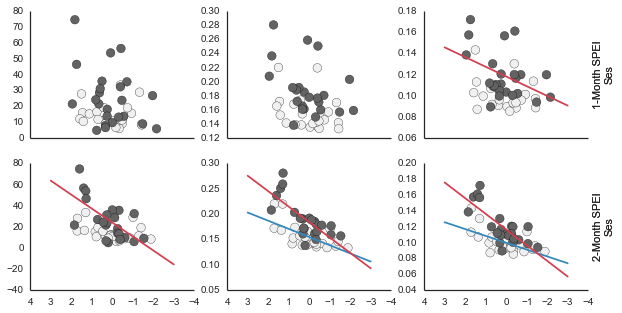

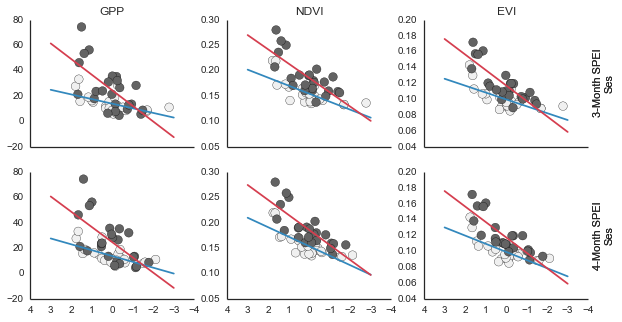

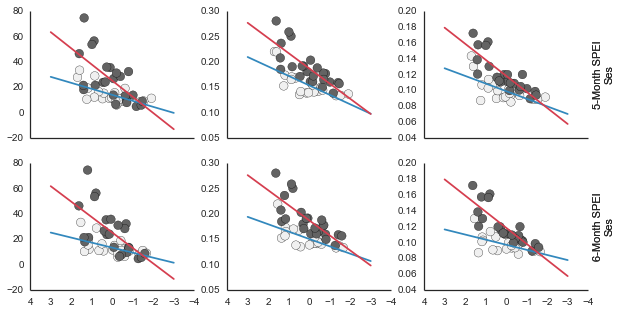

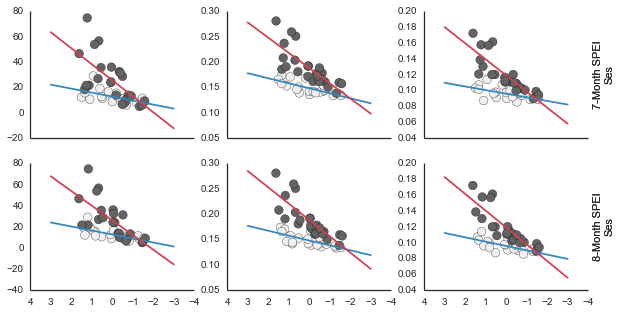

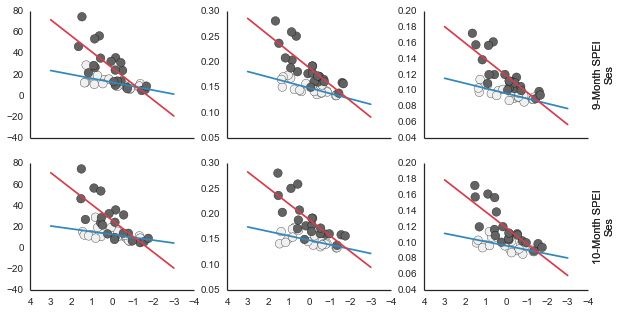

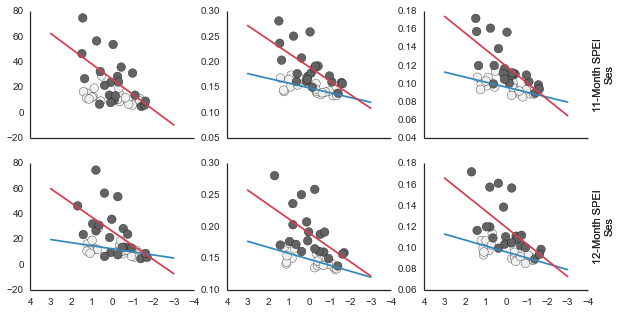

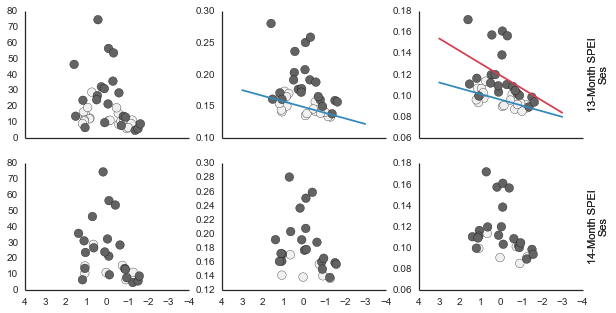

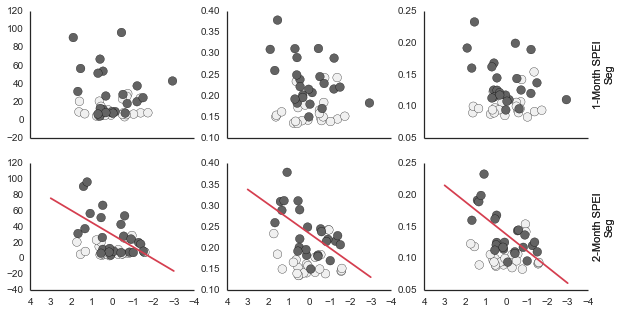

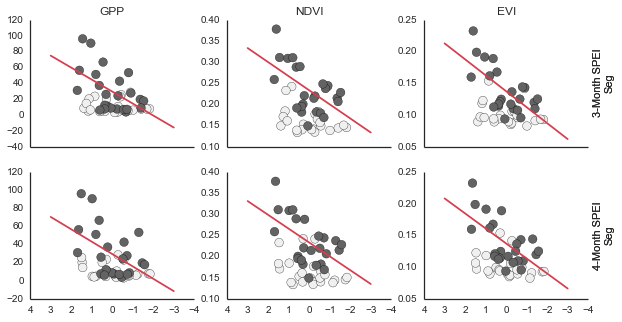

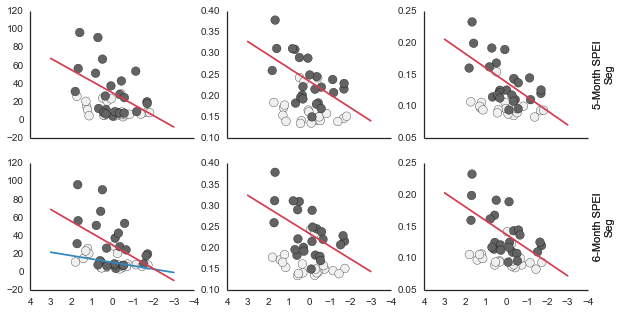

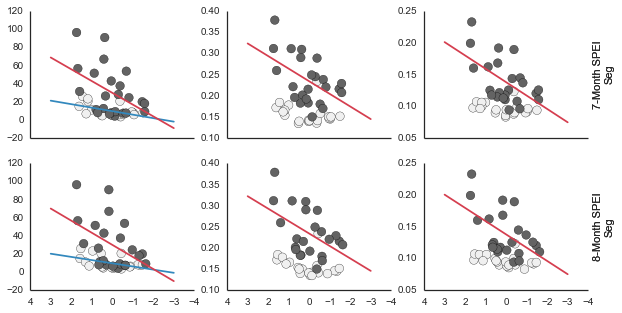

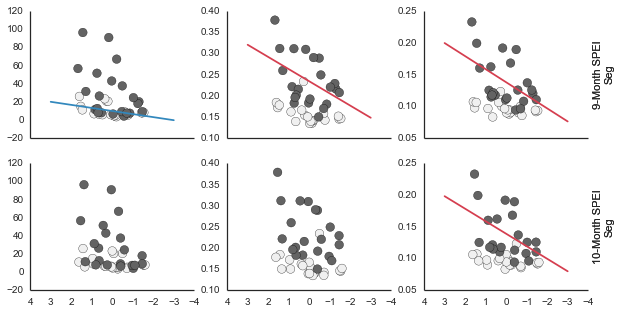

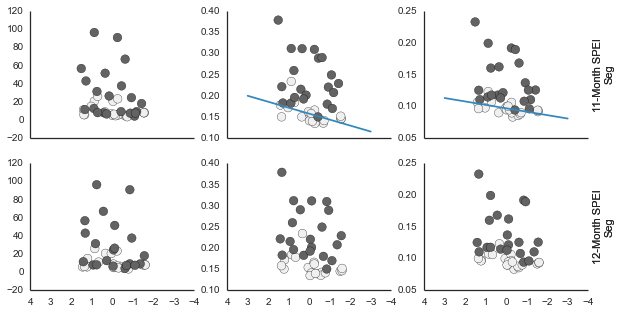

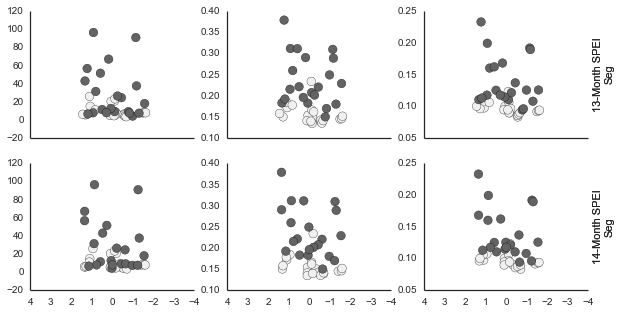

In [24]:
jet=plt.get_cmap('coolwarm')
sites = ['Vcm','Vcp','Mpj','Wjs','Ses','Seg']
idx = 0
linecols = ['#3288bd', '#d53e4f']
pointcols = ['#f0f0f0','#636363']
slopes = []
intercepts = []
thisvar = []
thissub = []
thismon = []
thissite = []
rsquares = []
for site in sites:
    mons = [1,2]
    for kki in np.arange(0,7,1):
        data = pd.read_csv(wrkDir + 'monthly_spei_flux_' + site + '.csv')
        cnames = data.columns.values 
        cnames[0] = 'Time'
        data.columns = cnames
        data.index = pd.to_datetime(data['Time'])
        # ------------ append NDVI and EVI columns -------------- #
        toAppend = MODIS_Monthly[MODIS_Monthly.Year > 2006]
        toAppend = toAppend[toAppend.Year < 2015]
        data = data[data.index.year < 2015]
        sitendvi = pd.DataFrame(dict(NDVI = toAppend[site]))
        sitendvi.index = data.index
        data['ndvi'] = sitendvi/10000

        toAppend = MODISEVI_Monthly[MODISEVI_Monthly.Year > 2006]
        toAppend = toAppend[toAppend.Year < 2015]
        data = data[data.index.year < 2015]
        siteevi = pd.DataFrame(dict(EVI = toAppend[site]))
        siteevi.index = data.index
        data['evi'] = siteevi/10000

        # ------------ Restrict months and years -- special for MCON FIRE ---- #
        if site == 'Vcm':
             data = data[data.index.year < 2014]
        data = data[(data.index.month > 3) & (data.index.month < 10)]
        aprmayjun = data[data.index.month < 7]
        julaugsep = data[data.index.month > 6]
        datasubs = [aprmayjun, julaugsep]
        # ------------ Plot scatters for SPEI by GPP, NDVI, and EVI ------ #
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, 
                                                               figsize=(10,5), sharex=True)
        plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
        fignum = 0
        axs = fig.axes
        for mon in mons:
            ax = axs[fignum]
            spei = 'spei' + str(mon) + 'mon'
            setid = 0
            for subset in datasubs:
            # Linear fit ----------------------------------

                y = []
                toFit = pd.DataFrame(dict(spei = subset[spei].ravel(), gpp = subset.GPP_g_int.ravel()))
                toFit = toFit.replace([np.inf, -np.inf], np.nan)
                ols = smf.ols('gpp ~ spei', data = toFit.dropna()).fit()
                slope = (ols.params['spei'])
                intercept = (ols.params['Intercept'])
                # ----- Build dataframe stats ----- #
                thisvar.append('gpp')
                thissite.append(site)
                if setid == 0:
                    thissub.append('Spring')
                else:
                    thissub.append('Fall')
                thismon.append(mon)

                ax.scatter(subset[spei].ravel(), subset.GPP_g_int.ravel(), 
                   color = pointcols[setid], marker = 'o',  
                           edgecolor='k', s = 75)

                for num in np.arange(-3, 4, 1):
                    y.append(intercept + slope*num)
                if ols.pvalues[0] < 0.05:
                    if ols.pvalues[1] < 0.05:
                        ax.plot(np.arange(-3,4,1), y, color = linecols[setid])
                        slopes.append(slope)
                        intercepts.append(intercept)
                        rsquares.append(ols.rsquared_adj)
                    else:
                        slopes.append(np.nan)
                        intercepts.append(np.nan)
                        rsquares.append(np.nan)
                else:
                    slopes.append(np.nan)
                    intercepts.append(np.nan)
                    rsquares.append(np.nan)

                    

                ax.set_xlim(4, -4)
                setid = setid + 1

            setid = 0        
            for subset in datasubs:
            # Linear fit ----------------------------------
                y = []
                toFit = pd.DataFrame(dict(spei = subset[spei].ravel(), ndvi = subset.ndvi.ravel()))
                toFit = toFit.replace([np.inf, -np.inf], np.nan)
                ols = smf.ols('ndvi ~ spei', data = toFit.dropna()).fit()
                slope = (ols.params['spei'])
                intercept = (ols.params['Intercept'])
                # ----- Build dataframe stats ----- #
                thisvar.append('ndvi')
                thissite.append(site)
                if setid == 0:
                    thissub.append('Spring')
                else:
                    thissub.append('Fall')
                thismon.append(mon)

                axs[fignum + 1].scatter(subset[spei].ravel(), subset.ndvi.ravel(), 
                   color = pointcols[setid], marker = 'o',  
                           edgecolor='k', s = 75)

                for num in np.arange(-3, 4, 1):
                    y.append(intercept + slope*num)
                if ols.pvalues[0] < 0.05:
                    if ols.pvalues[1] < 0.05:
                        axs[fignum + 1].plot(np.arange(-3,4,1), y, color = linecols[setid])
                        slopes.append(slope)
                        intercepts.append(intercept)
                        rsquares.append(ols.rsquared_adj)
                    else:
                        slopes.append(np.nan)
                        intercepts.append(np.nan)
                        rsquares.append(np.nan)
                else:
                    slopes.append(np.nan)
                    intercepts.append(np.nan)
                    rsquares.append(np.nan)

                setid = setid + 1


            setid = 0
            for subset in datasubs:
            # Linear fit ----------------------------------
                y = []
                toFit = pd.DataFrame(dict(spei = subset[spei].ravel(), evi = subset.evi.ravel()))
                toFit = toFit.replace([np.inf, -np.inf], np.nan)
                ols = smf.ols('evi ~ spei', data = toFit.dropna()).fit()
                slope = (ols.params['spei'])
                intercept = (ols.params['Intercept'])
                # ----- Build dataframe stats ----- #
                thisvar.append('evi')
                thissite.append(site)
                if setid == 0:
                    thissub.append('Spring')
                else:
                    thissub.append('Fall')
                thismon.append(mon)

                axs[fignum + 2].scatter(subset[spei].ravel(), subset.evi.ravel(), 
                   color = pointcols[setid], marker = 'o',  
                           edgecolor='k', s = 75)

                for num in np.arange(-3, 4, 1):
                    y.append(intercept + slope*num)
                if ols.pvalues[0] < 0.05:
                    if ols.pvalues[1] < 0.05:
                        axs[fignum + 2].plot(np.arange(-3,4,1), y, color = linecols[setid])
                        slopes.append(slope)
                        intercepts.append(intercept)
                        rsquares.append(ols.rsquared_adj)
                    else:
                        slopes.append(np.nan)
                        intercepts.append(np.nan)
                        rsquares.append(np.nan)
                else:
                    slopes.append(np.nan)
                    intercepts.append(np.nan)
                    rsquares.append(np.nan)



                setid = setid + 1
                ax2 = axs[fignum + 2].twinx()
                ax2.set_ylabel(str(mon) + '-Month SPEI \n' + site)
                ax2.set_yticklabels('')

            # Fig aesthetics ------------------------------
            if mon == 3:
                ax.set_title('GPP')
                axs[fignum + 1].set_title('NDVI')
                axs[fignum + 2].set_title('EVI')
            fignum = fignum + 3

            sns.set_style('white')
            sns.despine()
        mons = [x+2 for x in mons]
    idx = idx + 1


In [27]:
linefits = pd.DataFrame(dict(SITE = thissite, VAR = thisvar, 
                  SEASON = thissub, SPEI = thismon, 
                  SLOPE = slopes,  INTERCEPT = intercepts,
                  RSQUARED = rsquares))
onlysig = linefits.dropna().reset_index()

In [77]:
sites = ['Vcm', 'Vcp','Mpj','Wjs','Ses','Seg']
allvars = ['gpp']
seasons = ['Spring','Fall']
variables = []
diff = []
thissite = []
ratio = []
for site in sites:
    sitefit = onlysig[onlysig.SITE == site]
    for season in seasons:
        seasonfit = sitefit[sitefit.SEASON == season]
        

### First off, just boxplots of the slope over the entire range of SPEI bins. -- this includes 1 month to 14 month estimates of SPEI. Note that these plots highligh the relationship between change in drought and change in carbon uptake, or change in greenness. It follows that higher elevation sites with more leaf area should have larger responses, larger slopes. I binned the seasonality here for each site as well, so the spring and fall responses are pulled out

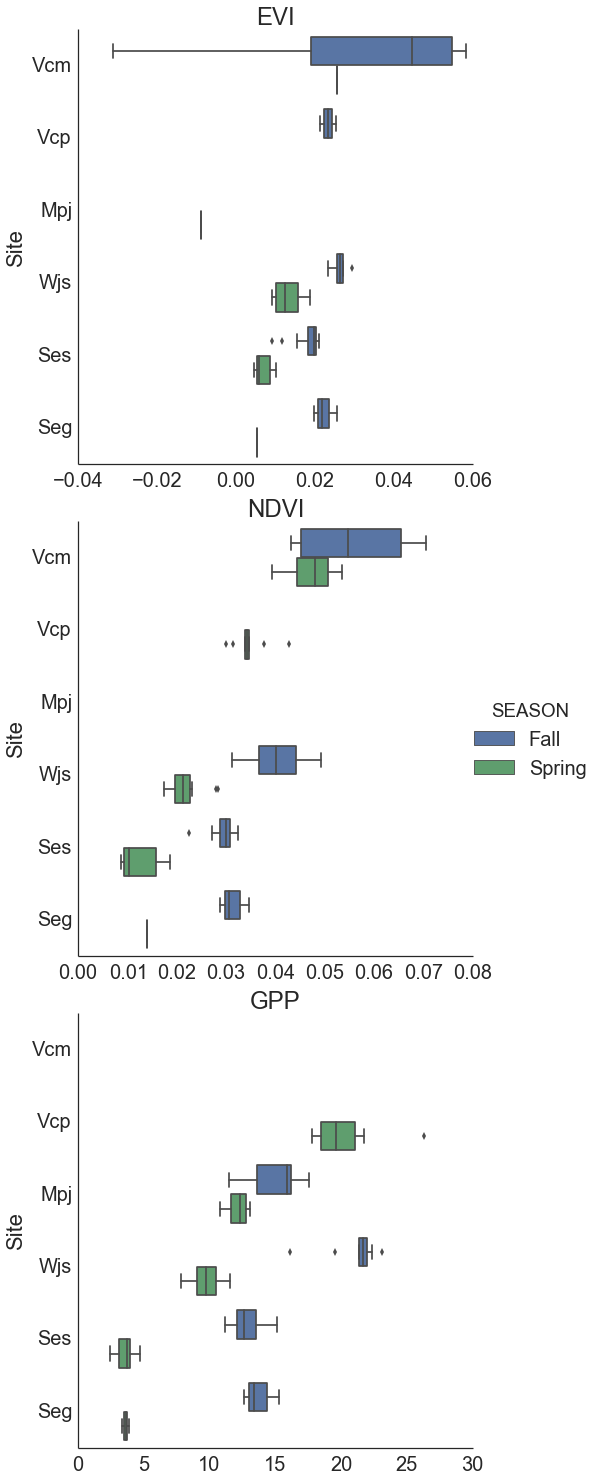

In [132]:
titles = ['EVI','NDVI','GPP']
with sns.plotting_context("notebook", font_scale=2):
    fig = sns.factorplot(y = 'SITE', x = 'SLOPE', row = 'VAR', 
                   hue = 'SEASON', data = onlysig, kind = 'box', 
                   sharex=False, size = 7)
    (fig.set_axis_labels("", "Site"))
    for ax, title in zip(fig.axes.flat, titles):
        ax.set_title(title)

### This next set is simply the max slope for each site by season.

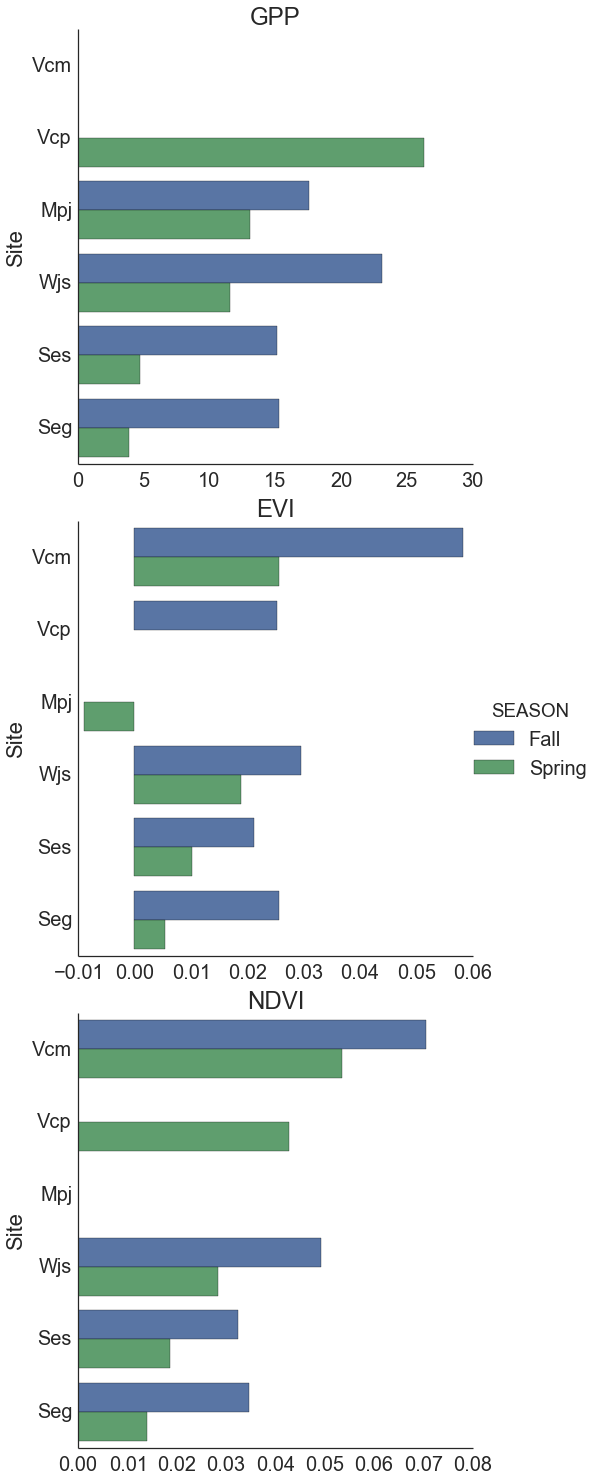

In [145]:
onlysigMax = onlysig.groupby(['SITE','SEASON','VAR']).max().reset_index()
titles = ['GPP','EVI','NDVI']

with sns.plotting_context("notebook", font_scale=2):
    fig = sns.factorplot(y = 'SITE', x = 'SLOPE', row = 'VAR', 
                   hue = 'SEASON', data = onlysigMax, kind = 'bar', 
                   sharex=False, size = 7, x_order = sites)
    (fig.set_axis_labels("", "Site"))
    for ax, title in zip(fig.axes.flat, titles):
        ax.set_title(title)

### Here we are looking at the correlations between the SPEI and either GPP, NDVI, or EVI -- again these are the BEST correlations by site and season. 

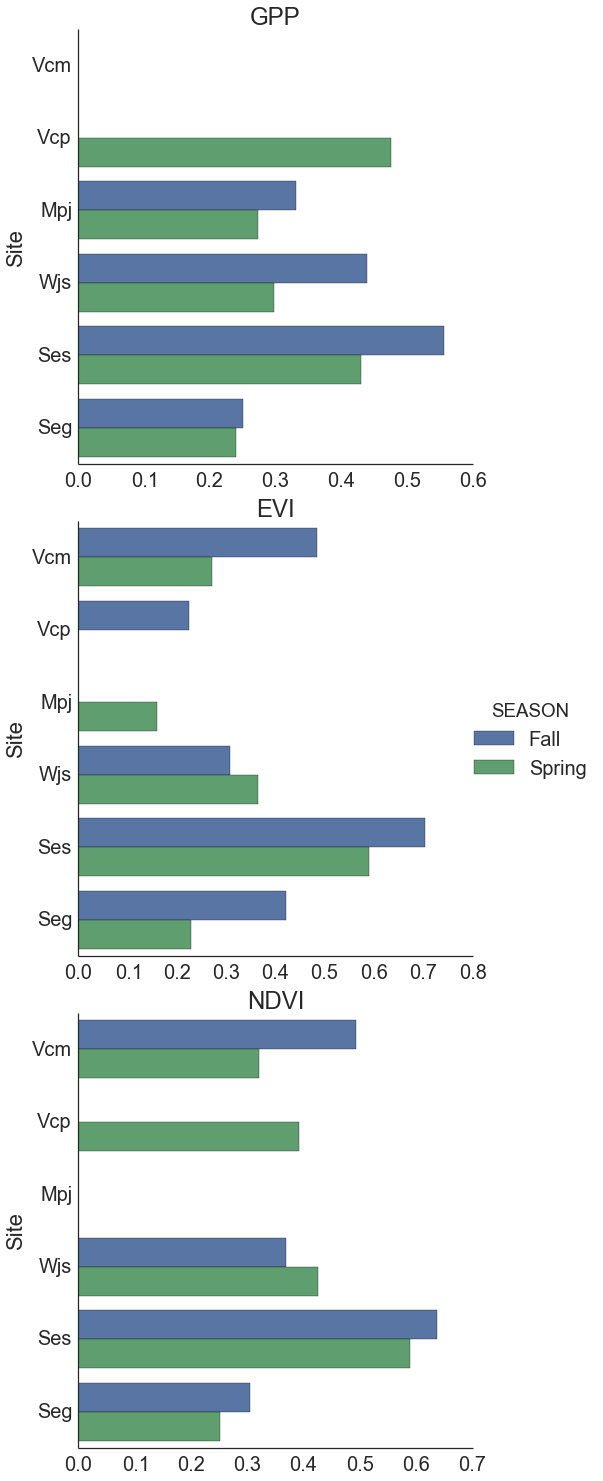

In [147]:
onlysigMax = onlysig.groupby(['SITE','SEASON','VAR']).max().reset_index()
titles = ['GPP','EVI','NDVI']

with sns.plotting_context("notebook", font_scale=2):
    fig = sns.factorplot(y = 'SITE', x = 'RSQUARED', row = 'VAR', 
                   hue = 'SEASON', data = onlysigMax, kind = 'bar', 
                   sharex=False, size = 7, x_order = sites)
    (fig.set_axis_labels("", "Site"))
    for ax, title in zip(fig.axes.flat, titles):
        ax.set_title(title)